Training set: 587 samples
Validation set: 147 samples
Test set: 184 samples
Class distribution in training: [269 318]
Starting training with 15 features, [32, 16, 8] hidden dimensions
Epoch 10/200, Train Loss: 0.648453, Val Loss: 0.657328, Val AUC: 0.781530
Epoch 20/200, Train Loss: 0.606690, Val Loss: 0.624531, Val AUC: 0.823694
Epoch 30/200, Train Loss: 0.564994, Val Loss: 0.593125, Val AUC: 0.833955
Epoch 40/200, Train Loss: 0.521013, Val Loss: 0.561942, Val AUC: 0.841791
Epoch 50/200, Train Loss: 0.476900, Val Loss: 0.530705, Val AUC: 0.850187
Epoch 60/200, Train Loss: 0.433840, Val Loss: 0.501934, Val AUC: 0.854851
Epoch 70/200, Train Loss: 0.394361, Val Loss: 0.478214, Val AUC: 0.860634
Epoch 80/200, Train Loss: 0.360810, Val Loss: 0.460577, Val AUC: 0.863619
Epoch 90/200, Train Loss: 0.335005, Val Loss: 0.449941, Val AUC: 0.869216
Epoch 100/200, Train Loss: 0.316746, Val Loss: 0.445084, Val AUC: 0.870522
Epoch 110/200, Train Loss: 0.304611, Val Loss: 0.443616, Val AUC: 0.872761


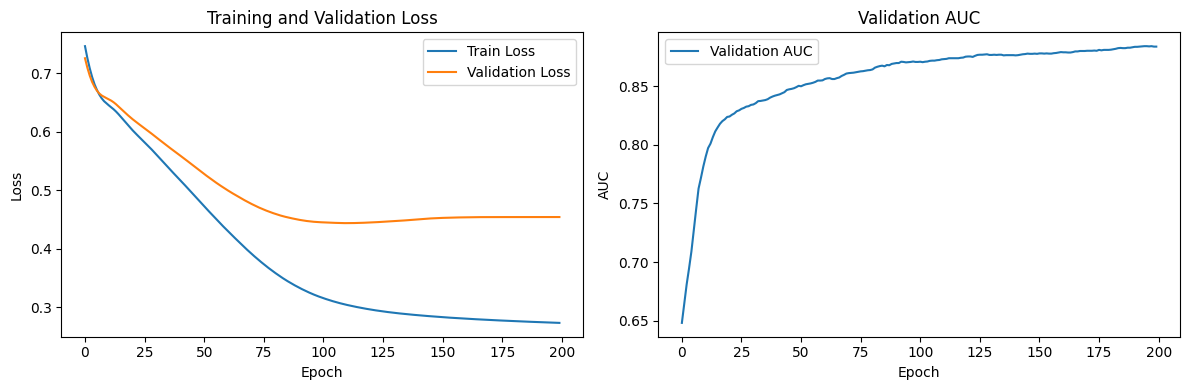

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd


class FeatureNN(nn.Module):
    """Neural network for a single feature in NAM."""
    def __init__(self, input_dim=1, hidden_dims=[64, 32], activation=nn.ReLU()):
        super(FeatureNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(activation)
            prev_dim = hidden_dim
        
        # Output layer - single value per feature
        layers.append(nn.Linear(prev_dim, 1))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        # Convert to tensor if it's not already
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float32)
            
        # Ensure x is properly shaped (batch_size, 1)
        if len(x.shape) == 1:
            x = x.unsqueeze(1)
        return self.model(x)


class NAM(nn.Module):
    """Neural Additive Model for binary classification."""
    def __init__(self, num_features, hidden_dims=[64, 32]):
        super(NAM, self).__init__()
        
        # Create a separate neural network for each feature
        self.feature_nns = nn.ModuleList([
            FeatureNN(input_dim=1, hidden_dims=hidden_dims) 
            for _ in range(num_features)
        ])
        
        # Bias term
        self.bias = nn.Parameter(torch.zeros(1))
        
        # Sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # Process each feature through its own network
        feature_outputs = []
        for i, feature_nn in enumerate(self.feature_nns):
            feature_output = feature_nn(x[:, i])
            feature_outputs.append(feature_output)
        
        # Sum all feature outputs + bias
        logits = torch.sum(torch.cat(feature_outputs, dim=1), dim=1, keepdim=True) + self.bias
        
        # Return both logits and probabilities
        probs = self.sigmoid(logits)
        return logits, probs
    
    def predict_proba(self, x):
        """Return probability estimates for samples."""
        self.eval()
        with torch.no_grad():
            _, probs = self.forward(x)
            return probs.cpu().numpy()
    
    def predict(self, x, threshold=0.5):
        """Return class predictions for samples."""
        probs = self.predict_proba(x)
        return (probs >= threshold).astype(int)
    
    def feature_importance(self, x):
        """Calculate feature importance based on contribution variance."""
        with torch.no_grad():
            # Get contribution of each feature
            contributions = []
            for i, feature_nn in enumerate(self.feature_nns):
                feature_output = feature_nn(x[:, i])
                contributions.append(feature_output)
            
            # Stack contributions
            contributions = torch.cat(contributions, dim=1)  # shape: [batch_size, num_features]
            
            # Calculate variance of each feature's contribution
            importance = contributions.var(dim=0).numpy()
            
            # Normalize to sum to 100%
            importance = importance / importance.sum() * 100
            
            return importance
    



def train_nam(X_train, y_train, X_val, y_val, X_test=None, y_test=None, 
              hidden_dims=[64, 32], lr=0.001, batch_size=64, epochs=300,
              early_stopping_patience=20, feature_names=None, weight_decay=0.0001,
              class_weights=None):
    """
    Train a Neural Additive Model for binary classification.
    
    Parameters:
    -----------
    X_train, y_train : numpy arrays or torch tensors
        Training data
    X_val, y_val : numpy arrays or torch tensors
        Validation data
    X_test, y_test : numpy arrays or torch tensors, optional
        Test data for final evaluation
    hidden_dims : list, default=[64, 32]
        Hidden layer dimensions for each feature network
    lr : float, default=0.001
        Learning rate
    batch_size : int, default=64
        Batch size for training
    epochs : int, default=300
        Maximum number of training epochs
    early_stopping_patience : int, default=20
        Number of epochs to wait for improvement before stopping
    feature_names : list, optional
        Names of features for plotting
    weight_decay : float, default=0.0001
        L2 regularization strength
    class_weights : list/array, optional
        Weights for each class to handle class imbalance
        
    Returns:
    --------
    model : NAM
        Trained Neural Additive Model
    history : dict
        Training history
    """
    # Convert numpy arrays to torch tensors if needed
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.float32)
        if X_test is not None:
            X_test = torch.tensor(X_test, dtype=torch.float32)
            y_test = torch.tensor(y_test, dtype=torch.float32)
    
    # Ensure y is 2D
    if len(y_train.shape) == 1:
        y_train = y_train.unsqueeze(1)
    if len(y_val.shape) == 1:
        y_val = y_val.unsqueeze(1)
    if y_test is not None and len(y_test.shape) == 1:
        y_test = y_test.unsqueeze(1)
    
    # Create data loaders
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model
    num_features = X_train.shape[1]
    model = NAM(num_features=num_features, hidden_dims=hidden_dims)
    
    # Define loss for binary classification
    if class_weights is not None:
        weights = torch.tensor(class_weights, dtype=torch.float32)
        criterion = nn.BCEWithLogitsLoss(pos_weight=weights[1]/weights[0])
    else:
        criterion = nn.BCEWithLogitsLoss()
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_auc': []
    }
    
    # Early stopping variables
    best_val_metric = -float('inf')  # Using AUC for early stopping
    best_model_state = None
    patience_counter = 0
    
    print(f"Starting training with {num_features} features, {hidden_dims} hidden dimensions")
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            # Forward pass
            logits, _ = model(batch_X)
            loss = criterion(logits, batch_y)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * batch_X.size(0)
        
        # Average training loss
        train_loss /= len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        
        # Validation phase
        model.eval()
        with torch.no_grad():
            val_logits, val_probs = model(X_val)
            val_loss = criterion(val_logits, y_val).item()
            
            # Calculate AUC for validation
            val_probs_np = val_probs.cpu().numpy()
            val_y_np = y_val.cpu().numpy()
            val_auc = roc_auc_score(val_y_np, val_probs_np)
        
        history['val_loss'].append(val_loss)
        history['val_auc'].append(val_auc)
        
        # Report progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}, Val AUC: {val_auc:.6f}')
        
        # Early stopping check (using AUC)
        if val_auc > best_val_metric:
            best_val_metric = val_auc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    # Final evaluation on test set
    if X_test is not None and y_test is not None:
        model.eval()
        with torch.no_grad():
            _, test_probs = model(X_test)
            test_preds = (test_probs > 0.5).float()
            
            test_probs_np = test_probs.cpu().numpy()
            test_preds_np = test_preds.cpu().numpy()
            test_y_np = y_test.cpu().numpy()
            
            # Calculate metrics
            test_accuracy = accuracy_score(test_y_np, test_preds_np)
            test_auc = roc_auc_score(test_y_np, test_probs_np)
            test_precision = precision_score(test_y_np, test_preds_np)
            test_recall = recall_score(test_y_np, test_preds_np)
            test_f1 = f1_score(test_y_np, test_preds_np)
            test_conf_matrix = confusion_matrix(test_y_np, test_preds_np)
            
            print(f'\nTest Results:')
            print(f'Accuracy: {test_accuracy:.6f}')
            print(f'AUC: {test_auc:.6f}')
            print(f'Precision: {test_precision:.6f}')
            print(f'Recall: {test_recall:.6f}')
            print(f'F1 Score: {test_f1:.6f}')
            print(f'Confusion Matrix:')
            print(test_conf_matrix)
    
    # Plot feature functions
    
    # Feature importance
    importance = model.feature_importance(X_train)
    top_features = np.argsort(-importance)
    
    print("\nFeature Importance (%):")
    for i in top_features:
        if feature_names and i < len(feature_names):
            print(f"{feature_names[i]}: {importance[i]:.2f}%")
        else:
            print(f"Feature {i+1}: {importance[i]:.2f}%")
    
    return model, history


def evaluate_nam(model, X, y=None, threshold=0.5, batch_size=256):
    """
    Evaluate a trained NAM model on new data for binary classification.
    
    Parameters:
    -----------
    model : NAM
        Trained Neural Additive Model
    X : numpy array or torch tensor
        Features
    y : numpy array or torch tensor, optional
        Target values (binary). If None, only predictions are returned.
    threshold : float, default=0.5
        Decision threshold for binary classification
    batch_size : int, default=256
        Batch size for evaluation
        
    Returns:
    --------
    metrics : dict
        Evaluation metrics
    """
    # Convert to torch tensors if needed
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)
    
    # Create appropriate data loader
    if y is not None:
        if not isinstance(y, torch.Tensor):
            y = torch.tensor(y, dtype=torch.float32)
        
        # Ensure y is 2D
        if len(y.shape) == 1:
            y = y.unsqueeze(1)
            
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    else:
        dataset = torch.utils.data.TensorDataset(X)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    # Evaluation
    model.eval()
    all_probs = []
    all_true = []
    
    with torch.no_grad():
        if y is not None:
            for batch_X, batch_y in loader:
                # Forward pass
                _, probs = model(batch_X)
                
                # Collect predictions and true values
                all_probs.append(probs.cpu().numpy())
                all_true.append(batch_y.cpu().numpy())
        else:
            for (batch_X,) in loader:
                # Forward pass
                _, probs = model(batch_X)
                
                # Collect predictions
                all_probs.append(probs.cpu().numpy())
    
    # Concatenate batches
    y_probs = np.vstack(all_probs)
    
    # If no ground truth provided, just return predictions
    if y is None:
        # For single sample prediction, return probability value
        if y_probs.shape[0] == 1:
            return y_probs[0][0]
        
        # For feature contribution analysis of a single sample
        feature_contribs = []
        if X.shape[0] == 1:
            for i, feature_nn in enumerate(model.feature_nns):
                with torch.no_grad():
                    feature_output = feature_nn(X[:, i])
                    feature_contribs.append(feature_output.item())
        
            return {
                'probability': y_probs[0][0],
                'prediction': 1 if y_probs[0][0] >= threshold else 0,
                'feature_contributions': feature_contribs
            }
            
        return {
            'probabilities': y_probs,
            'predictions': (y_probs >= threshold).astype(int)
        }
    
    # Concatenate true values
    y_true = np.vstack(all_true)
    
    # Get class predictions
    y_pred = (y_probs >= threshold).astype(int)
    
    # Calculate basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    auroc = roc_auc_score(y_true, y_probs)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Calculate balanced accuracy
    tn, fp, fn, tp = conf_matrix.ravel()
    sensitivity = tp / (tp + fn)  # Recall of positive class
    specificity = tn / (tn + fp)  # Recall of negative class
    balanced_accuracy = (sensitivity + specificity) / 2
    
    # Calculate AUPRC
    from sklearn.metrics import precision_recall_curve, auc
    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_probs)
    auprc = auc(recall_curve, precision_curve)
    
    # Feature-level analysis (only for test set, not for individual predictions)
    feature_contribs = []
    for i, feature_nn in enumerate(model.feature_nns):
        with torch.no_grad():
            feature_output = feature_nn(X[:, i]).cpu().numpy()
            feature_contribs.append(feature_output)
    
    # Print results
    print(f"Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.6f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.6f}")
    print(f"AUROC: {auroc:.6f}")
    print(f"AUPRC: {auprc:.6f}")
    print(f"Precision: {precision:.6f}")
    print(f"Recall: {recall:.6f}")
    print(f"F1 Score: {f1:.6f}")
    print(f"Confusion Matrix:")
    print(conf_matrix)
    
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_accuracy,
        'auroc': auroc,
        'auprc': auprc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'probabilities': y_probs,
        'predictions': y_pred,
        'feature_contributions': feature_contribs
    }

def load_data(X_train_path, y_train_path, X_test_path, y_test_path, val_split=0.2, random_state=42):
    """
    Load train and test data from separate file paths and create a validation set.
    
    Args:
        X_train_path: Path to X training data file
        y_train_path: Path to y training data file 
        X_test_path: Path to X test data file
        y_test_path: Path to y test data file
        val_split: Fraction of training data to use for validation
        random_state: Random seed for reproducibility
    
    Returns:
        X_train, y_train, X_val, y_val, X_test, y_test, feature_names
    """
    # Load datasets
    X_train_full = pd.read_csv(X_train_path)
    y_train_full = pd.read_csv(y_train_path)
    X_test = pd.read_csv(X_test_path)
    y_test = pd.read_csv(y_test_path)
    
    # Get feature names
    feature_names = X_train_full.columns.tolist()
    
    # Convert to numpy arrays if they aren't already
    if isinstance(X_train_full, pd.DataFrame):
        X_train_full = X_train_full.values
    if isinstance(y_train_full, pd.DataFrame) or isinstance(y_train_full, pd.Series):
        y_train_full = y_train_full.values.ravel()  # Flatten to 1D array
    if isinstance(X_test, pd.DataFrame):
        X_test = X_test.values
    if isinstance(y_test, pd.DataFrame) or isinstance(y_test, pd.Series):
        y_test = y_test.values.ravel()  # Flatten to 1D array
    
    # Split training data to create validation set
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=val_split, random_state=random_state,
        stratify=y_train_full  # Ensure balanced classes in train/val splits
    )
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Class distribution in training: {np.bincount(y_train.astype(int))}")
    
    return X_train, y_train, X_val, y_val, X_test, y_test, feature_names


def threshold_optimization(model, X_val, y_val, metric='f1'):
    """
    Find the optimal threshold for binary classification based on a specified metric.
    
    Parameters:
    -----------
    model : NAM
        Trained Neural Additive Model
    X_val : numpy array or torch tensor
        Validation features
    y_val : numpy array or torch tensor
        Validation targets (binary)
    metric : str, default='f1'
        Metric to optimize ('accuracy', 'precision', 'recall', 'f1')
        
    Returns:
    --------
    optimal_threshold : float
        Optimal threshold for the specified metric
    """
    # Convert to torch tensors if needed
    if not isinstance(X_val, torch.Tensor):
        X_val = torch.tensor(X_val, dtype=torch.float32)
    
    # Get probabilities for validation set
    probs = model.predict_proba(X_val)
    
    # Prepare y_val as numpy array
    if isinstance(y_val, torch.Tensor):
        y_val_np = y_val.cpu().numpy()
    else:
        y_val_np = y_val
    
    # Flatten if needed
    if len(y_val_np.shape) > 1:
        y_val_np = y_val_np.ravel()
    
    # Test various thresholds
    thresholds = np.linspace(0.1, 0.9, 81)  # Test thresholds from 0.1 to 0.9
    
    best_score = -float('inf')
    best_threshold = 0.5
    
    for threshold in thresholds:
        preds = (probs >= threshold).astype(int)
        
        if metric == 'accuracy':
            score = accuracy_score(y_val_np, preds)
        elif metric == 'precision':
            score = precision_score(y_val_np, preds)
        elif metric == 'recall':
            score = recall_score(y_val_np, preds)
        elif metric == 'f1':
            score = f1_score(y_val_np, preds)
        else:
            raise ValueError(f"Unknown metric: {metric}")
        
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    print(f"Optimal threshold for {metric}: {best_threshold:.3f} (Score: {best_score:.6f})")
    return best_threshold


# Example usage
if __name__ == "__main__":
    # Load data
    X_train, y_train, X_val, y_val, X_test, y_test, feature_names = load_data(
        "/home/taekim/ml4h_p2/X_train_scaled.csv", "/home/taekim/ml4h_p2/y_train.csv", "/home/taekim/ml4h_p2/X_test_scaled.csv", "/home/taekim/ml4h_p2/y_test.csv"
    )
    
    # Check for class imbalance
    train_class_counts = np.bincount(y_train.astype(int))
    class_weights = None
    
    if train_class_counts[0] > 2 * train_class_counts[1] or train_class_counts[1] > 2 * train_class_counts[0]:
        print("Class imbalance detected, using class weights")
        class_weights = len(y_train) / (2 * train_class_counts)
    
    # Train model
    model, history = train_nam(
        X_train, y_train, X_val, y_val, X_test, y_test,
        hidden_dims=[32, 16, 8], lr=0.001, batch_size=1024, epochs=200,
        early_stopping_patience=20, feature_names=feature_names,
        class_weights=class_weights
    )
    
    # Find optimal threshold
    optimal_threshold = threshold_optimization(model, X_val, y_val, metric='f1')
    
    # Final evaluation with optimal threshold
    metrics = evaluate_nam(model, X_test, y_test, threshold=optimal_threshold)
    
    # Save model
    torch.save(model.state_dict(), "binary_nam_model.pt")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(history['val_auc'], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.title('Validation AUC')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    


In [38]:
#---------- Visualization and Interpretation Functions ----------#

def plot_feature_contribution_curves(model, X_train, feature_names=None, num_points=100, 
                                     num_cols=5, figsize=None):
    """
    Plot the contribution of each feature across its range of values.
    
    Parameters:
    -----------
    model : NAM
        Trained Neural Additive Model
    X_train : DataFrame or numpy array
        Training data used to determine feature value ranges
    feature_names : list, optional
        Names of features for plot labels
    num_points : int, default=100
        Number of points to sample for each feature
    num_cols : int, default=5
        Number of columns in the plot grid
    figsize : tuple, optional
        Figure size, default is calculated based on the number of features
    """
    num_features = len(model.feature_nns)
    
    # Calculate number of rows based on features and columns
    num_rows = num_features // num_cols + (num_features % num_cols > 0)
    
    # Determine figure size if not provided
    if figsize is None:
        figsize = (num_cols * 3, num_rows * 3)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Handle single-feature case
    if num_features == 1:
        axes = np.array([axes])
    
    # Ensure we have a flattened array of axes for iterating
    axes_flat = axes.flatten()
    
    # Convert to DataFrame if it's not already
    if not isinstance(X_train, pd.DataFrame):
        if feature_names is None:
            feature_names = [f"Feature {i+1}" for i in range(X_train.shape[1])]
        X_train = pd.DataFrame(X_train, columns=feature_names)
    
    # If no feature names provided, use DataFrame columns
    if feature_names is None:
        feature_names = X_train.columns
    
    # Plot each feature's contribution
    for i, feature_nn in enumerate(model.feature_nns):
        # Get feature range
        feature_min = X_train.iloc[:, i].min()
        feature_max = X_train.iloc[:, i].max()
        
        # Create evenly spaced points
        feature_values = torch.linspace(feature_min, feature_max, steps=num_points).unsqueeze(1)
        
        # Get contributions
        with torch.no_grad():
            contributions = feature_nn(feature_values).numpy().flatten()
        
        # Plot
        ax = axes_flat[i]
        ax.plot(feature_values.numpy(), contributions)
        ax.set_title(feature_names[i])
        ax.set_xlabel('Feature Value')
        ax.set_ylabel('Contribution')
        ax.axhline(y=0, color='r', linestyle='--', alpha=0.3)
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots
    for ax in axes_flat[num_features:]:
        ax.set_visible(False)
    
    fig.tight_layout()
    plt.savefig('feature_contributions.png')
    plt.show()
    
    
    return fig


def plot_feature_importance(model, X_train, feature_names=None, top_n=None, figsize=(10, 6)):
    """
    Plot the mean absolute contribution of each feature to show feature importance.
    
    Parameters:
    -----------
    model : NAM
        Trained Neural Additive Model
    X_train : DataFrame or numpy array
        Training data
    feature_names : list, optional
        Names of features for plot labels
    top_n : int, optional
        Only plot the top N most important features
    figsize : tuple, default=(10, 6)
        Figure size for the plot
    """
    # Convert to torch tensor if needed
    if not isinstance(X_train, torch.Tensor):
        X_train = torch.tensor(X_train.values.astype(np.float32)
                              if isinstance(X_train, pd.DataFrame)
                              else X_train.astype(np.float32))
    
    # Get feature names
    if feature_names is None:
        if isinstance(X_train, pd.DataFrame):
            feature_names = X_train.columns
        else:
            feature_names = [f"Feature {i+1}" for i in range(X_train.shape[1])]
    
    # Calculate mean absolute contribution for each feature
    mean_contributions = []
    for i, feature_nn in enumerate(model.feature_nns):
        with torch.no_grad():
            contributions = feature_nn(X_train[:, i].unsqueeze(1))
            # Use absolute contribution for importance
            mean_contribution = torch.mean(torch.abs(contributions)).item()
            mean_contributions.append(mean_contribution)
    
    # Create DataFrame for easy sorting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': mean_contributions
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Take only top N if specified
    if top_n is not None:
        importance_df = importance_df.head(top_n)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bars = ax.barh(importance_df['Feature'], importance_df['Importance'])
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center')
    
    ax.set_xlabel('Mean Absolute Contribution')
    ax.set_title('Feature Importance')
    ax.invert_yaxis()  # Make the top feature appear at the top
    
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()
    
    
    return fig


def plot_sample_contributions(model, X_samples, feature_names=None, labels=None, 
                             colors=None, figsize=(15, 6), n_cols=2):
    """
    Plot feature contributions for individual samples.
    
    Parameters:
    -----------
    model : NAM
        Trained Neural Additive Model
    X_samples : list of arrays or DataFrame rows
        List of samples to analyze
    feature_names : list, optional
        Names of features for plot labels
    labels : list, optional
        Labels for each sample
    colors : list, optional
        Colors for each sample
    figsize : tuple, default=(15, 6)
        Figure size for the entire plot
    n_cols : int, default=2
        Number of columns in the plot grid
    """
    n_samples = len(X_samples)
    n_rows = (n_samples + n_cols - 1) // n_cols  # Ceiling division
    
    # Create default labels and colors if not provided
    if labels is None:
        labels = [f"Sample {i+1}" for i in range(n_samples)]
    
    if colors is None:
        # Use default color cycle
        colors = plt.cm.tab10.colors[:n_samples]
        
    # Set default feature names if not provided
    if feature_names is None:
        if isinstance(X_samples[0], pd.Series):
            feature_names = X_samples[0].index
        else:
            feature_names = [f"Feature {i+1}" for i in range(len(X_samples[0]))]
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle single row/column cases
    if n_samples == 1:
        axes = np.array([axes])
    
    # Ensure axes is a 2D array for consistent indexing
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Calculate feature contributions for each sample
    for sample_idx, sample in enumerate(X_samples):
        row_idx = sample_idx // n_cols
        col_idx = sample_idx % n_cols
        ax = axes[row_idx, col_idx]
        
        # Convert sample to tensor if needed
        if not isinstance(sample, torch.Tensor):
            sample_tensor = torch.tensor(sample.values.astype(np.float32) 
                                       if isinstance(sample, pd.Series)
                                       else sample.astype(np.float32))
        else:
            sample_tensor = sample
            
        # Ensure sample is a 1D tensor
        if len(sample_tensor.shape) > 1:
            sample_tensor = sample_tensor.squeeze()
            
        # Calculate contribution of each feature
        contributions = []
        for i, feature_nn in enumerate(model.feature_nns):
            with torch.no_grad():
                contribution = feature_nn(sample_tensor[i].unsqueeze(0)).item()
                contributions.append(contribution)
        
        # Plot
        bars = ax.barh(range(len(feature_names)), contributions, 
                      align='center', color=colors[sample_idx])
        ax.set_yticks(range(len(feature_names)))
        ax.set_yticklabels(feature_names)
        ax.invert_yaxis()  # Reverse order to have first feature at the top
        ax.axvline(x=0, color='r', linestyle='--', alpha=0.3)
        ax.set_xlabel('Contribution')
        ax.set_title(labels[sample_idx])
        
        # Add a bold line at y=0
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Annotate total sum
        total = sum(contributions)
        bias = model.bias.item()
        logit = total + bias
        prob = 1 / (1 + np.exp(-logit))
        ax.annotate(f'Sum: {total:.3f}\nBias: {bias:.3f}\nLogit: {logit:.3f}\nProb: {prob:.3f}',
                   xy=(0.95, 0.05), xycoords='axes fraction',
                   ha='right', va='bottom',
                   bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))
    
    # Hide unused subplots
    for i in range(n_samples, n_rows * n_cols):
        row_idx = i // n_cols
        col_idx = i % n_cols
        axes[row_idx, col_idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('sample_contributions.png')
    plt.show()
    
    
    return fig


def plot_precision_recall_curve(model, X, y, figsize=(10, 6)):
    """
    Plot the precision-recall curve for a binary classification model.
    
    Parameters:
    -----------
    model : NAM
        Trained Neural Additive Model
    X : numpy array or torch tensor
        Features
    y : numpy array or torch tensor
        Target values (binary)
    figsize : tuple, default=(10, 6)
        Figure size for the plot
    """
    from sklearn.metrics import precision_recall_curve, average_precision_score, auc
    
    # Convert to tensor if needed
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)
    
    # Get predictions
    probs = model.predict_proba(X)
    
    # Ensure y is numpy array
    if isinstance(y, torch.Tensor):
        y = y.numpy()
    
    # Flatten if needed
    if len(y.shape) > 1:
        y = y.ravel()
    if len(probs.shape) > 1:
        probs = probs.ravel()
    
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y, probs)
    avg_precision = average_precision_score(y, probs)
    
    # Calculate AUPRC
    auprc = auc(recall, precision)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(recall, precision, lw=2, label=f'AUPRC = {auprc:.3f}')
    
    # Add no-skill line (ratio of positive class)
    no_skill = np.sum(y) / len(y)
    ax.plot([0, 1], [no_skill, no_skill], '--', label=f'No Skill = {no_skill:.3f}')
    
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig


def plot_roc_curve(model, X, y, figsize=(10, 6)):
    """
    Plot the ROC curve for a binary classification model.
    
    Parameters:
    -----------
    model : NAM
        Trained Neural Additive Model
    X : numpy array or torch tensor
        Features
    y : numpy array or torch tensor
        Target values (binary)
    figsize : tuple, default=(10, 6)
        Figure size for the plot
    """
    from sklearn.metrics import roc_curve, roc_auc_score
    
    # Convert to tensor if needed
    if not isinstance(X, torch.Tensor):
        X = torch.tensor(X, dtype=torch.float32)
    
    # Get predictions
    probs = model.predict_proba(X)
    
    # Ensure y is numpy array
    if isinstance(y, torch.Tensor):
        y = y.numpy()
    
    # Flatten if needed
    if len(y.shape) > 1:
        y = y.ravel()
    if len(probs.shape) > 1:
        probs = probs.ravel()
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y, probs)
    auroc = roc_auc_score(y, probs)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(fpr, tpr, lw=2, label=f'AUROC = {auroc:.3f}')
    ax.plot([0, 1], [0, 1], '--', label='Random')
    
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig


Plotting feature contribution curves...


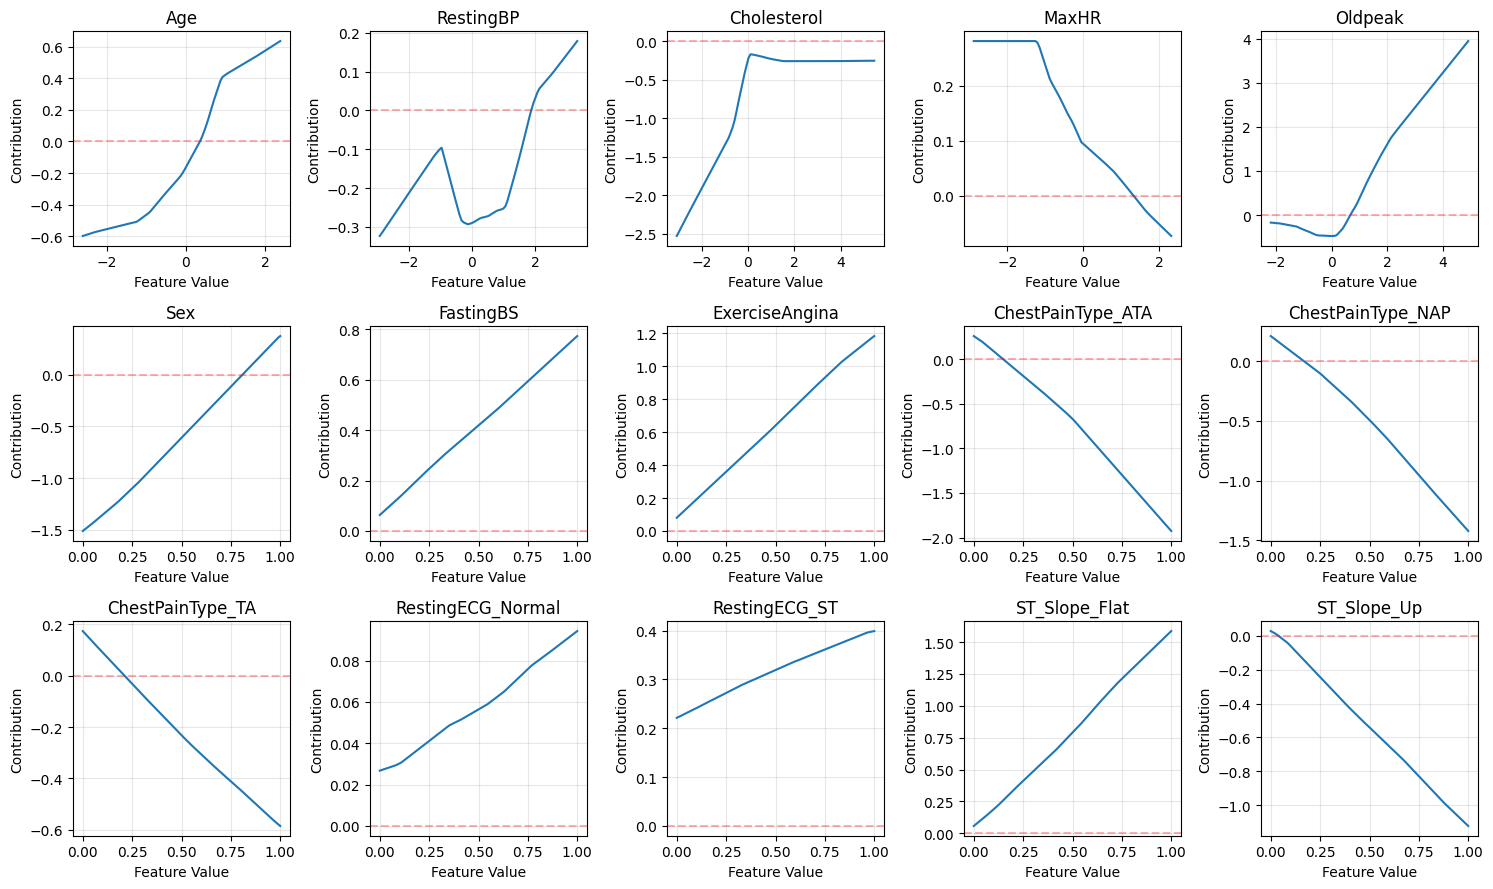


Plotting feature importance...


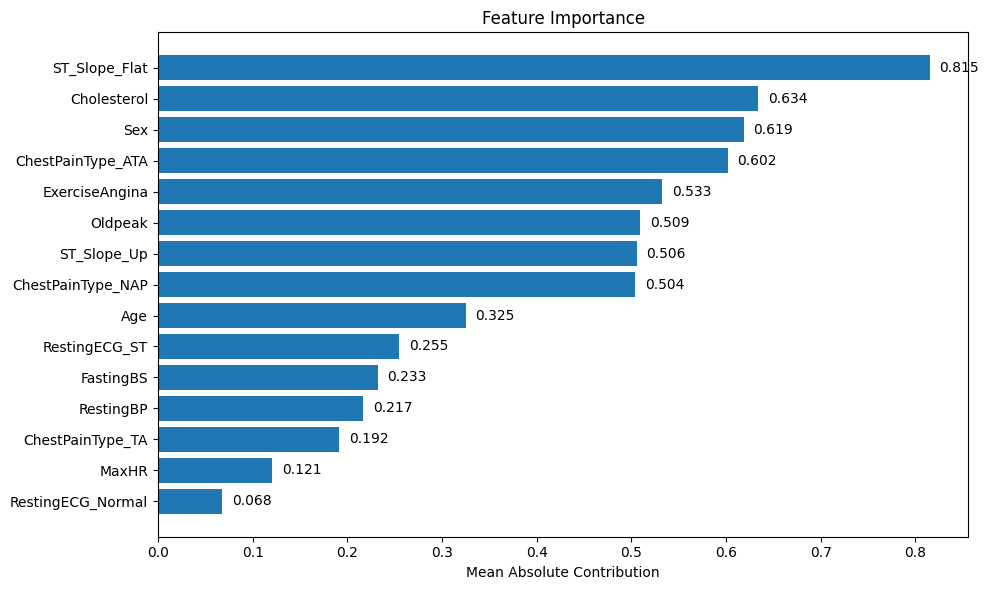


Plotting ROC curve...


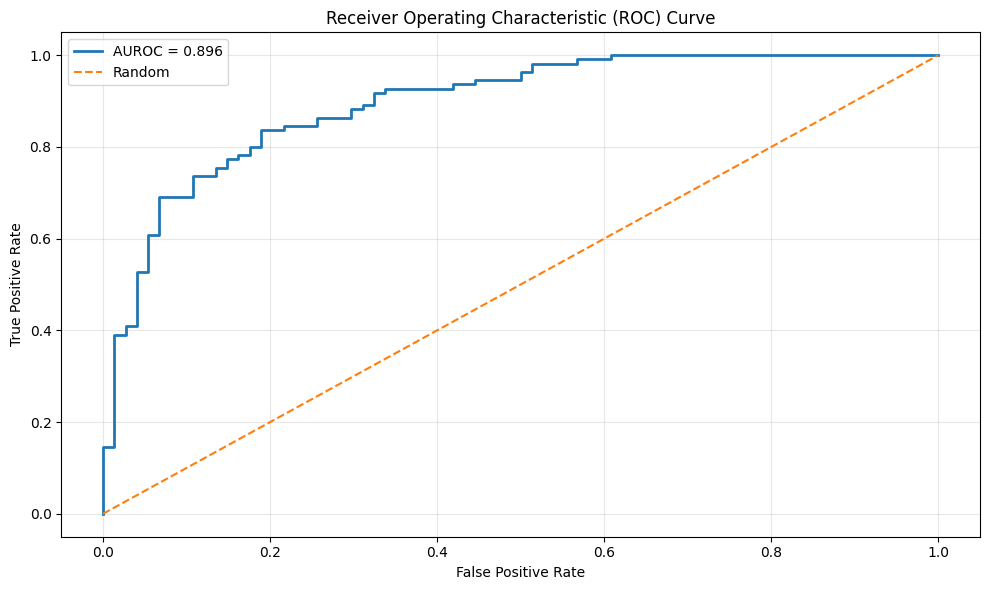


Plotting Precision-Recall curve...


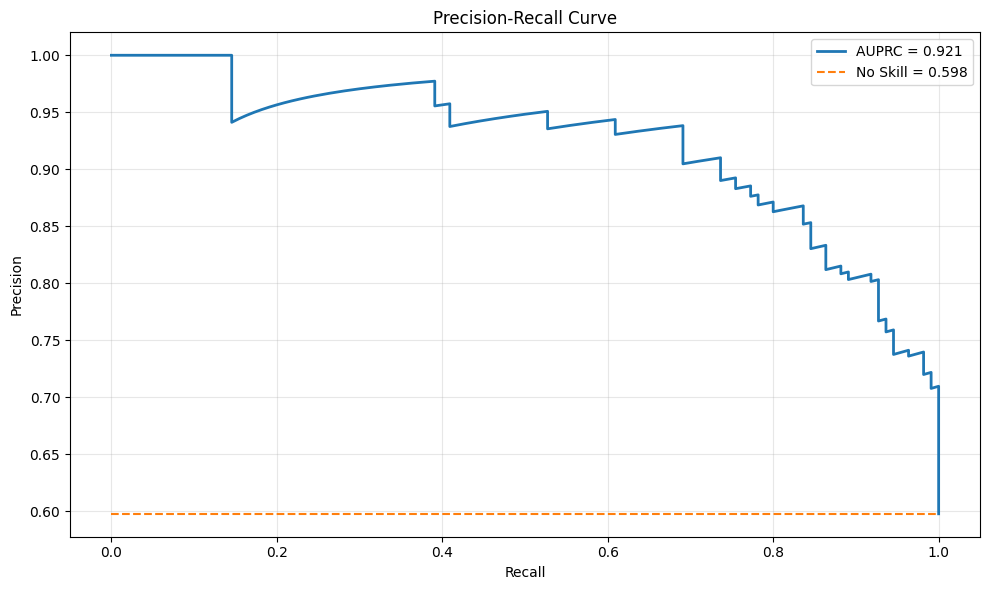


Plotting sample contributions...


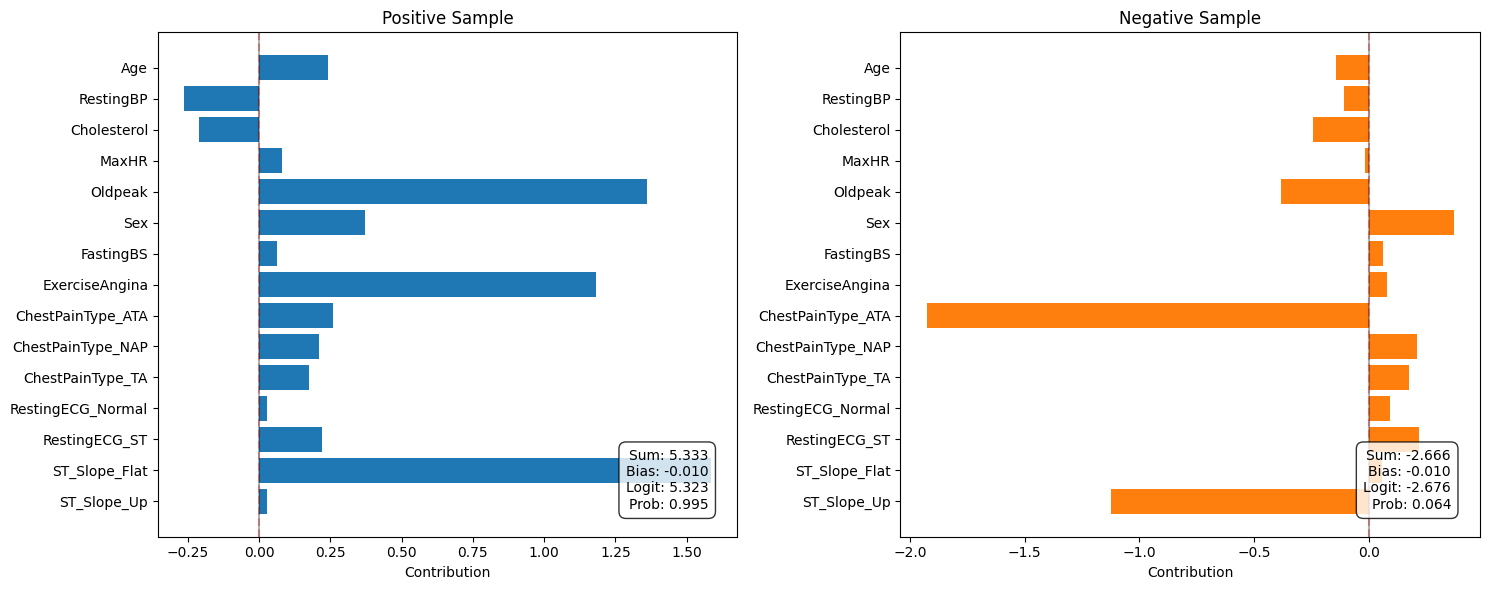

In [41]:
# After your model training and evaluation...

# 1. Plot feature contribution curves
print("\nPlotting feature contribution curves...")
fig_contributions = plot_feature_contribution_curves(
    model, X_train, feature_names, num_points=100, num_cols=5
)

# 2. Plot feature importance
print("\nPlotting feature importance...")
fig_importance = plot_feature_importance(
    model, X_train, feature_names
)

# 3. Plot ROC and Precision-Recall curves
print("\nPlotting ROC curve...")
fig_roc = plot_roc_curve(model, X_test, y_test)

print("\nPlotting Precision-Recall curve...")
fig_pr = plot_precision_recall_curve(model, X_test, y_test)

# 4. Sample Analysis
# Get a few samples from each class for analysis
pos_samples = []
neg_samples = []

# Assuming y_test is a 1D array or has shape (n, 1)
y_test_flat = y_test.flatten() if hasattr(y_test, 'flatten') else y_test

for i in range(len(y_test_flat)):
    if y_test_flat[i] == 1 and len(pos_samples) < 1:
        pos_samples.append(X_test[i])
    elif y_test_flat[i] == 0 and len(neg_samples) < 1:
        neg_samples.append(X_test[i])
    
    if len(pos_samples) == 2 and len(neg_samples) == 1:
        break

# Combine samples
samples = pos_samples + neg_samples
labels = ["Positive Sample", 
         "Negative Sample",]

print("\nPlotting sample contributions...")
fig_samples = plot_sample_contributions(
    model, samples, feature_names, labels
)
    

